# Intro

In this notebook, we are going to scale things a bit.
we will build a MLP, with two options of nonlinearity: tanh, and Relu


# Imports and setup

In [673]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
from tqdm import tqdm
%matplotlib inline

In [674]:
with open('data/combined_english_names_cleaned.txt','r') as f:
# with open('data/combined_arabic_names_cleaned.txt','r') as f:

    names = [x.strip().lower() for x in f.readlines()]
names[:10]

['abdelrahman',
 'albiloni',
 'wsamaiah',
 'sammar',
 'alrshidiah',
 'jllai',
 'aljroshi',
 'hazizah',
 'noshin',
 'akhdan']

In [675]:
len(names)


52813

In [676]:
chars = ['.'] + sorted(list(set(''.join(names))))
stoi = { c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}
print(stoi)
print(itos)
print( sorted(list(set(''.join(names)))))

{'.': 0, '-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'y': 25, 'z': 26}
{0: '.', 1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'y', 26: 'z'}
['-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'y', 'z']


In [677]:
def build_dataset(names, context_size, p=False):
    X = []
    Y = []

    for name in names:

        if p :
            print(name)
        context = [stoi['.']] * context_size

        for c in name + '.':
            X.append(context)
            Y.append(stoi[c])

            if p:
                print( ''.join(itos[x] for x in context) ,f' --> {c}')

            context = context[1:] + [stoi[c]]

    
    X = torch.tensor(X)
    Y = torch.tensor(Y)


    return X,Y

In [678]:
## MLP Setup

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 200
CONTEXT_SIZE = 5
VOCAB_SIZE = len(chars)
EPS  = 1e-5

In [679]:
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
x_train, y_train = build_dataset( names[:n1], CONTEXT_SIZE )
x_val, y_val = build_dataset( names[n1:n2], CONTEXT_SIZE )
x_test, y_test = build_dataset( names[n2:], CONTEXT_SIZE )


# Messy way

In [680]:

embedding = torch.randn((len(chars), EMBEDDING_SIZE))
w1 = torch.randn(( EMBEDDING_SIZE * CONTEXT_SIZE,HIDDEN_SIZE)) * (5/3) / ( EMBEDDING_SIZE * CONTEXT_SIZE)**0.5
b1 = torch.randn((HIDDEN_SIZE)) * 0.001
w2 = torch.randn((HIDDEN_SIZE,VOCAB_SIZE)) * (5/3) / (HIDDEN_SIZE)**0.5
b2 = torch.randn((VOCAB_SIZE)) * 0

bngain = torch.ones((1,HIDDEN_SIZE))
bnbias = torch.zeros((1,HIDDEN_SIZE))

bnmean_running = torch.zeros((1,HIDDEN_SIZE))
bnstd_running = torch.ones((1,HIDDEN_SIZE))


parameters = [embedding,w1,b1,w2,b2, bnbias,bngain]

for p in parameters:
    p.requires_grad = True

## Total number of params
print('Total number of parameter is: ', sum(p.nelement() for p in parameters))

Total number of parameter is:  16297


In [681]:
best_params = []
best_loss= 1e9

In [682]:
def batch_norm(x):

    global bnstd_running
    global bnmean_running
    mean =  x.mean(0, keepdim=True)
    std = x.std(0, keepdim=True)


    # as the batch size gets bigger, we can make our momentum factor bigger, as batches
    # tend to have the same mean
    momentum = 0.001
    with torch.no_grad():
        bnmean_running = (1-momentum) * bnmean_running + momentum * mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * std

    return  (x - mean) /std + EPS

In [683]:
lr = 0.2
STEPS = 10
BATCH_SIZE = 64
lossi = []

for i in tqdm(range(STEPS)):
    
    batch_indexes = torch.randint(0,x_train.shape[0], (BATCH_SIZE,))
    
    x_batch = x_train[batch_indexes]
    y_batch =  y_train[batch_indexes]

    emb = embedding[x_batch]
    input = emb.view(-1,emb.shape[1] * emb.shape[2] )

    ## NOTE: we can git rid of b1, as it's gonna get removed when we remove the mean in the normalization
    
    h =  input @ w1 + b1

    h =  batch_norm(h)

    h =  bngain*h + bnbias


    act =  torch.tanh(h)


    logits = act @ w2 + b2


    loss = F.cross_entropy(logits, y_batch)

    for p in parameters:
            p.grad = None

    loss.backward()

    if loss < best_loss:
        best_params = [embedding,w1,b1,w2,b2,bnbias,bngain]   
        best_loss =  loss

    if i % 100_000 == 0:
        lr = lr * 0.1

    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        assert(p.grad != None)
        p.data +=   -lr * p.grad


    if i % 100_00 == 0:
        print(f'{i:7d}/{STEPS:7d}: {loss.item():.5f}')
    lossi.append(loss.log10().item())
    



100%|██████████| 10/10 [00:00<00:00, 643.04it/s]

      0/     10: 3.91650


In [684]:
print(best_loss)

tensor(3.1287, grad_fn=<NllLossBackward0>)


### Plot activations and see the percentage of saturated gradients

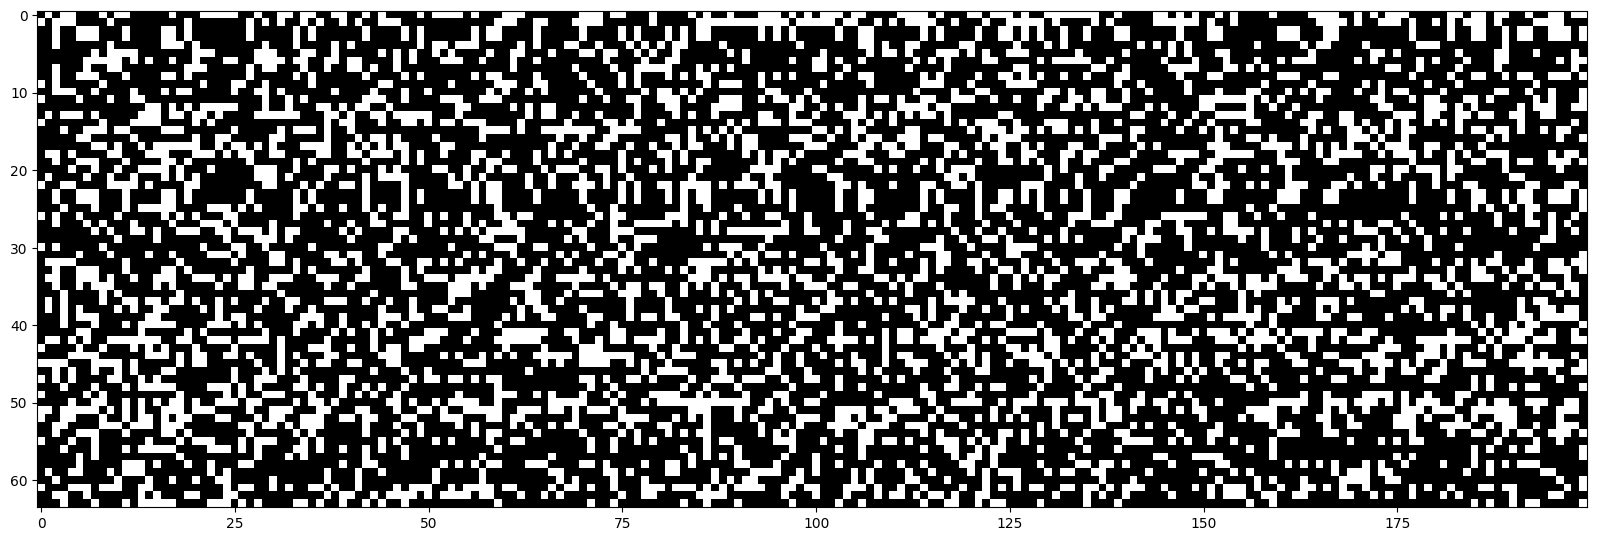

In [685]:
plt.figure(figsize=(20,10))

plt.imshow(h.abs() > 0.99, cmap='gray' , interpolation='nearest')

(array([  2.,   2.,   3.,   2.,   5.,  12.,  17.,  23.,  32.,  44.,  73.,
         96., 106., 150., 268., 269., 431., 504., 503., 624., 666., 664.,
        725., 705., 769., 743., 700., 765., 597., 539., 552., 486., 430.,
        333., 253., 200., 138., 102.,  75.,  58.,  38.,  31.,  16.,  22.,
          9.,  10.,   6.,   1.,   0.,   1.]),
 array([-3.73280716, -3.58146524, -3.43012357, -3.27878165, -3.12743974,
        -2.97609806, -2.82475615, -2.67341423, -2.52207232, -2.37073064,
        -2.21938872, -2.06804681, -1.91670501, -1.76536322, -1.6140213 ,
        -1.46267951, -1.31133771, -1.15999579, -1.008654  , -0.85731214,
        -0.70597029, -0.55462843, -0.40328661, -0.25194475, -0.10060291,
         0.05073893,  0.20208077,  0.35342261,  0.50476444,  0.65610629,
         0.80744815,  0.95879   ,  1.11013186,  1.26147366,  1.41281557,
         1.56415737,  1.71549916,  1.86684108,  2.01818299,  2.16952467,
         2.32086658,  2.4722085 ,  2.62355018,  2.77489209,  2.92623401,
 

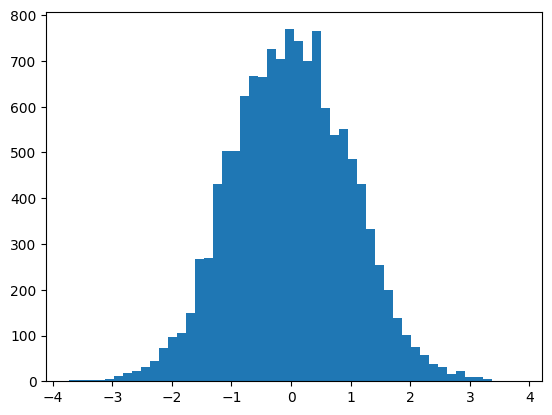

In [686]:
plt.hist(h.view(-1).detach().cpu(), bins=50)


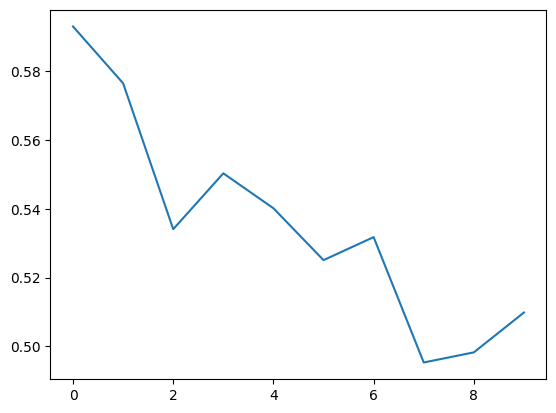

In [687]:
plt.plot(lossi)

In [688]:
embedding[x_test].shape

torch.Size([44065, 5, 10])

In [689]:
x_t = embedding[x_train].view(x_train.shape[0],-1) @ w1 + b1

training_std =  x_t.std(0, keepdim=True)
training_mean = x_t.mean(0, keepdim=True,dtype=torch.float) 

In [690]:
print( torch.sum(torch.abs(training_mean- bnmean_running)))
print( torch.sum(torch.abs(training_std-bnstd_running)))


tensor(189.2484, grad_fn=<SumBackward0>)
tensor(99.1983, grad_fn=<SumBackward0>)


# Making thing more tidy

- make class for linear layer
- class for batch norm
- class for tanh activation


In [691]:
class Linear():
    def __init__(self, in_n, out_n, bias=True) -> None:
        self.params = []
        self.have_bias = bias
        self.weight = torch.randn((in_n,out_n)) / (in_n**0.5)
        self.params.append(self.weight)

        self.bias = None
        if self.have_bias:
            self.bias = torch.zeros(out_n)
            self.params.append(self.bias)
    
    def __call__(self,x, is_training =True):
        self.is_training = is_training

        self.out = x @ self.params[0]
        if self.have_bias:
            self.out += self.params[1]
            return self.out

    def set_parameters(self,p):
        self.params = p
        # self.weight = p[0]
        # self.bias = p[1]
        # self.params = [p]

    def parameters(self):
        return self.params
        

In [692]:
class BatchNorm():
    def __init__(self, in_n,eps=1e-5, momentum = 0.1) -> None:
        self.eps = eps
        self.is_training = True
        self.momentum = momentum
        self.running_mean = torch.zeros(in_n)
        self.running_std  = torch.ones(in_n)
        self.gain = torch.ones(in_n)
        self.bias = torch.zeros(in_n)
        self.params = [self.gain , self.bias]


    def __call__(self, x,  is_training= True):

        self.is_training = is_training
        if self.is_training:
            mean = x.mean(0,keepdims= True)
            ## unbiased??
            std = x.std(0,keepdims= True)

            self.out =  self.params[0] * (x - mean / (std + self.eps**0.5)) + self.params[1]

            with torch.no_grad():
                self.running_mean = self.running_mean * (1- self.momentum) \
                    + self.momentum * mean
                self.running_std = self.running_std * (1- self.momentum) \
                + self.momentum * std

        else:
            # print(self.running_mean , self.running_std)
            self.out =  self.params[0] * (x - self.running_mean / (self.running_std + self.eps**0.5)) + self.params[1]



        return self.out

    def set_parameters(self,p):
        self.params = p
        # self.gain = p[0]
        # self.bias = p[1]
        # self.params = [self.gain , self.bias]
    def set_mean_std(self, conf):
        self.running_mean = conf[0]
        self.running_std = conf[1]
    def get_mean_std(self):
        return [self.running_mean, self.running_std]

    def parameters(self):
        return self.params


In [693]:
class Activation():
    def __init__(self, activation='tanh'):
        self.params = []
        if activation == 'tanh':
            self.forward = self._forward_tanh
        elif activation == 'relu':
            self.forward = self._forward_relu
        else:
            raise Exception('Only tanh, and relu activations are supported')

    def _forward_relu(self,x):
        return torch.relu(x)
    def _forward_tanh(self,x):
        return torch.tanh(x)

    def __call__(self, x, is_training= True):

        self.is_training = is_training

        
        self.out = self.forward(x)
        return self.out
    
    def set_parameters(self,p):
        self.params = p
    def parameters(self):
        return self.params

### Stepup and Training

In [694]:
VOCAB_SIZE

27

In [695]:


## SETUP
n_embed = 10
n_hidden = 100
activation = 'relu'
embedding = torch.randn((VOCAB_SIZE,n_embed))

layers = [
    Linear(CONTEXT_SIZE*n_embed , n_hidden),BatchNorm(n_hidden), Activation(activation),
    Linear(n_hidden, n_hidden),BatchNorm(n_hidden), Activation(activation),
    Linear(n_hidden, n_hidden),BatchNorm(n_hidden), Activation(activation),
    Linear(n_hidden , VOCAB_SIZE)
]

parameters = [embedding] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True

In [696]:
def forward(x_batch, is_training):
    x_batch = embedding[x_batch]
    x = x_batch.view(x_batch.shape[0], -1)

    for layer in layers:
        x = layer(x, is_training)
    return x

In [697]:
STEPS = 2_00000
BATCH_SIZE = 128
lossi = []

for i in tqdm(range(STEPS)):
    indices = torch.randint(0, x_train.shape[0],(BATCH_SIZE,))
    x_batch , y_batch = x_train[indices], y_train[indices]

    
    x = forward(x_batch, True)

    loss = F.cross_entropy(x,y_batch)

    ################### BACKWARD ##################
    for p in parameters:
        p.grad = None

    loss.backward()
    lr = 0.01 if i < STEPS*0.5 else 0.001
    with torch.no_grad():
        for p in parameters:
            p += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{STEPS:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  0%|          | 105/200000 [00:00<06:18, 528.11it/s]

      0/ 200000: 3.5997


  5%|▌         | 10072/200000 [00:21<08:00, 395.67it/s]

  10000/ 200000: 1.9910


 10%|█         | 20040/200000 [00:44<06:07, 489.95it/s]

  20000/ 200000: 2.2079


 15%|█▌        | 30088/200000 [01:05<06:21, 445.77it/s]

  30000/ 200000: 2.0727


 20%|██        | 40069/200000 [01:25<05:39, 470.97it/s]

  40000/ 200000: 1.7862


 25%|██▌       | 50059/200000 [01:47<04:49, 517.36it/s]

  50000/ 200000: 1.9650


 30%|███       | 60056/200000 [02:08<04:29, 518.47it/s]

  60000/ 200000: 1.9508


 35%|███▌      | 70049/200000 [02:29<06:32, 330.93it/s]

  70000/ 200000: 1.7744


 40%|████      | 80080/200000 [02:50<04:07, 484.40it/s]

  80000/ 200000: 1.6253


 45%|████▌     | 90091/200000 [03:11<03:54, 468.10it/s]

  90000/ 200000: 2.0134


 50%|█████     | 100053/200000 [03:32<03:11, 520.84it/s]

 100000/ 200000: 1.7919


 55%|█████▌    | 110090/200000 [03:53<02:56, 509.46it/s]

 110000/ 200000: 1.7686


 60%|██████    | 120041/200000 [04:14<02:36, 512.46it/s]

 120000/ 200000: 1.7737


 65%|██████▌   | 130081/200000 [04:35<02:45, 423.02it/s]

 130000/ 200000: 1.9032


 70%|███████   | 140094/200000 [04:55<01:58, 504.77it/s]

 140000/ 200000: 1.8166


 75%|███████▌  | 150075/200000 [05:16<01:35, 520.78it/s]

 150000/ 200000: 2.0719


 80%|████████  | 160050/200000 [05:37<01:35, 419.20it/s]

 160000/ 200000: 1.9056


 85%|████████▌ | 170075/200000 [05:58<01:10, 423.78it/s]

 170000/ 200000: 1.8371


 90%|█████████ | 180084/200000 [06:19<00:36, 547.58it/s]

 180000/ 200000: 1.8423


 95%|█████████▌| 190080/200000 [06:39<00:19, 513.47it/s]

 190000/ 200000: 1.8981


100%|██████████| 200000/200000 [07:00<00:00, 475.87it/s]


### evaluation and inference

In [698]:
@torch.no_grad()
def eval(split):

    x,y = {

        'train' : (x_train, y_train),
        'val' : (x_val, y_val),
        'test' : (x_test, y_test),
    }[split]
    x = forward(x,False)
    loss = F.cross_entropy(x,y)


    print(split, loss.item())
    

In [699]:
eval('train')
eval('val')
eval('test')


train 1.8110476732254028
val 1.8473742008209229
test 1.8424553871154785


In [700]:
## saving weights

parameters = [embedding] + [layer.parameters() for layer in layers ]

bn_conf = []
for l in layers:
    if l.__class__.__name__ == "BatchNorm":
        bn_conf.append(l.get_mean_std())

save_dict = {
    'params': parameters,
    'bn_conf': bn_conf
}

torch.save(save_dict,'weights/en_dataset_weights.pt')

In [701]:
def generate_name():

    # embedding,w1,b1,w2,b2,bnbias,bngain = best_params 
    w = ''
    last_ch = [0]* CONTEXT_SIZE
    while True:
        last_ch = torch.tensor(last_ch).unsqueeze(0)
        x = forward(last_ch, False)
        last_ch = last_ch.clone().detach().squeeze(0)

        p = torch.softmax(x, dim=1)

        next_ch = torch.multinomial(p, num_samples=1, replacement=True).item()

        last_ch = last_ch.tolist()
        last_ch = last_ch[1:] + [next_ch]

        w += itos[next_ch]

        if next_ch == 0:
            break

    return w

In [702]:
for i in range(10):
   print(generate_name())

shil.
nirun.
muqaitt.
abdulkadirah.
abdalailai.
dualoon.
mzaiamaiah.
alniol.
alamdhurman.
dwazalai.


In [703]:
english_params = torch.load('weights/ar_dataset_weights.pt')

n_layers = [
    Linear(CONTEXT_SIZE*n_embed , n_hidden),BatchNorm(n_hidden), Activation(activation),
    Linear(n_hidden, n_hidden),BatchNorm(n_hidden), Activation(activation),
    Linear(n_hidden, n_hidden),BatchNorm(n_hidden), Activation(activation),
    Linear(n_hidden , VOCAB_SIZE)
]

p1 = n_layers[0].parameters()

j = 0
n_embedding = english_params[0]
for i,l in enumerate(n_layers):
    if l.parameters():
        l.set_parameters( english_params[i+1] )
    if l.__class__.__name__ == "BatchNorm":
        l.set_mean_std(bn_conf[j])
        j+=1


# for i,l in enumerate(layers):
#     for j,p in enumerate(l.parameters()):
#         print(p == n_layers[i].parameters()[j])

# print(p1 == p2)

KeyError: 0

In [ ]:

# print(n_embedding == embedding)
layers = n_layers
embedding = n_embedding
# print(n_layers[0].parameters()[0] == layers[0].parameters()[0])

In [ ]:
for i in range(10):
   print(generate_name())

خبيني.
الهيسي.
رامكي.
اللحيت.
الوزير.
العرادل.
عباشنة.
قندون.
عبيبان.
المغنوع.


In [ ]:
# for i, l in enumerate(layers):
#     print(torch.equal(layers[i].parameters(),english_params[i+1])) 

# print(torch.equal(embedding,english_params[0]))

# RESULTS LOG

### With Random init

train 1.948970913887024
val 1.9736006259918213
test 1.9740004539489746
### With squashed parameters around 0
train 1.9164973497390747
val 1.9359190464019775
test 1.9330960512161255

train 1.9137359857559204
val 1.9327006340026855
test 1.9292832612991333

### Using Batch Normalization 
train 1.9241148233413696
val 1.9510610103607178
test 1.9430794715881348


### Using all the above and context length of 5
train 1.7000510692596436
val 1.8077348470687866
test 1.8030661344528198